In [ ]:
#IMPORTS
import os
import cv2
import tqdm
import pickle
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.python.util.deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

In [2]:
#PATH
dataset_path = "DATASET"

In [3]:
#MEDIAPOSE
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True,
    min_detection_confidence=0.5)

In [4]:
#CLASS LABELS
class_labels = {
    "downdog": 0,
    "goddess": 1,
    "plank": 2, 
    "tree": 3,
    "warrior2": 4
}
pose_label = ["Downdog","Goddess","Plank","Tree","Warrior II"]

In [5]:
#MODEL
def create_model():
    model = keras.Sequential()
    model.add(
        layers.Conv1D(
            filters=16,
            kernel_size=3,
            activation=keras.activations.relu,
            padding="same",
            input_shape=(33, 2)
        )
    )
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.2))
    model.add(layers.MaxPooling1D())
    model.add(
        layers.Conv1D(
            filters=16,
            kernel_size=3,
            activation=keras.activations.relu,
            padding="same",
        )
    )
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.2))
    model.add(layers.Flatten())
    model.add(layers.Dense(5, activation=keras.activations.softmax))
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=[tf.keras.metrics.CategoricalAccuracy(name="accuracy")]
    )
    return model

In [6]:
#TRAIN MODEL
def train_model(model, train_dataset, val_dataset):
    history = model.fit(train_dataset, epochs=100, validation_data=val_dataset)
    model.save("save/predict.model")
    return history

In [7]:
#PLOTTING ACCURACY
def plot_accgraph(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

In [8]:
#LOAD DATASET
def load_dataset(
        dataset_label,
        data_path,
        class_labels,
    ):
    data = []
    labels = []
    for class_name in class_labels.keys():
        path = f"{data_path}/{dataset_label}/{class_name}"
        print(f"Loading {dataset_label} Data for Class Name: {class_name}")
        for filename in tqdm.tqdm(os.listdir(path), position=0):
            image = cv2.imread(f"{path}/{filename}")
            results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            if not results.pose_landmarks:
                continue
            sample = []
            for lm in results.pose_landmarks.landmark:
                sample.append((lm.x, lm.y))
            data.append(sample)
            label_sample = np.zeros(5)
            label_sample[class_labels[class_name]] = 1
            labels.append(label_sample)
    return np.array(data), np.array(labels)

In [9]:
#LOAD DATA
def load_data(data_path, class_labels):
    train_data, train_labels = load_dataset(
        "TRAIN",
        data_path,
        class_labels,
    )
    test_data, test_labels = load_dataset(
        "TEST",
        data_path,
        class_labels,
    )
    train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels)).batch(32)
    test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels)).batch(32)
    return train_dataset, test_dataset

In [10]:
#LOADING DATASET
train_dataset, test_dataset = load_data(dataset_path, class_labels)

Loading TRAIN Data for Class Name: downdog


100%|████████████████████████████████████████████████████████████████████████████████| 223/223 [00:40<00:00,  5.48it/s]


Loading TRAIN Data for Class Name: goddess


100%|████████████████████████████████████████████████████████████████████████████████| 180/180 [00:31<00:00,  5.79it/s]


Loading TRAIN Data for Class Name: plank


100%|████████████████████████████████████████████████████████████████████████████████| 266/266 [00:42<00:00,  6.28it/s]


Loading TRAIN Data for Class Name: tree


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:28<00:00,  5.55it/s]


Loading TRAIN Data for Class Name: warrior2


100%|████████████████████████████████████████████████████████████████████████████████| 252/252 [00:41<00:00,  6.02it/s]


Loading TEST Data for Class Name: downdog


100%|██████████████████████████████████████████████████████████████████████████████████| 97/97 [00:17<00:00,  5.52it/s]


Loading TEST Data for Class Name: goddess


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:17<00:00,  4.65it/s]


Loading TEST Data for Class Name: plank


100%|████████████████████████████████████████████████████████████████████████████████| 115/115 [00:23<00:00,  4.87it/s]


Loading TEST Data for Class Name: tree


100%|██████████████████████████████████████████████████████████████████████████████████| 69/69 [00:15<00:00,  4.57it/s]


Loading TEST Data for Class Name: warrior2


100%|████████████████████████████████████████████████████████████████████████████████| 109/109 [00:18<00:00,  5.74it/s]


In [11]:
#LOADING MODEL
model = create_model()

In [12]:
#TRAINING MODEL
history=train_model(model, train_dataset, test_dataset)

Epoch 1/100
33/33 [==============================] - 3s 22ms/step - loss: 2.4069 - accuracy: 0.2313 - val_loss: 1.6124 - val_accuracy: 0.2495
Epoch 2/100
33/33 [==============================] - 0s 9ms/step - loss: 2.1640 - accuracy: 0.2610 - val_loss: 1.5997 - val_accuracy: 0.2538
Epoch 3/100
33/33 [==============================] - 0s 10ms/step - loss: 1.9407 - accuracy: 0.3061 - val_loss: 1.5857 - val_accuracy: 0.2151
Epoch 4/100
33/33 [==============================] - 0s 10ms/step - loss: 1.8729 - accuracy: 0.3225 - val_loss: 1.5678 - val_accuracy: 0.2108
Epoch 5/100
33/33 [==============================] - 0s 10ms/step - loss: 1.7142 - accuracy: 0.3676 - val_loss: 1.5427 - val_accuracy: 0.2194
Epoch 6/100
33/33 [==============================] - 0s 10ms/step - loss: 1.6122 - accuracy: 0.3868 - val_loss: 1.5072 - val_accuracy: 0.2430
Epoch 7/100
33/33 [==============================] - 0s 12ms/step - loss: 1.5668 - accuracy: 0.4098 - val_loss: 1.4638 - val_accuracy: 0.2581
Epoch 8

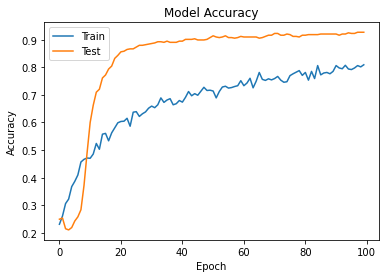

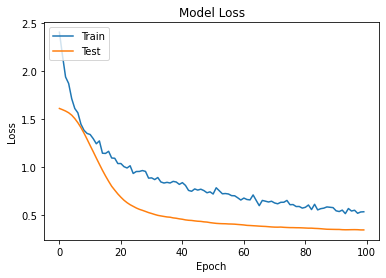

In [13]:
#ACCURACY
plot_accgraph(history)

In [14]:
#TRAINED MODEL
model = keras.models.load_model("save/predict.model")

In [15]:
#MAKE PREDICTIONS
def predict_with_static_image(model,filepath):
    input_frame = cv2.imread(filepath)
    input_frame = cv2.cvtColor(input_frame, cv2.COLOR_BGR2RGB)
    results = pose.process(image=input_frame)
    output_image = input_frame.copy()
    label = "Unknown Pose"
    accuracy = 0
    mp_drawing.draw_landmarks(output_image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)
    sample = []
    for lm in results.pose_landmarks.landmark:
        sample.append((lm.x, lm.y))
    prediction = model(np.array(sample)[np.newaxis, :, :])
    p=np.array(prediction)
    label=pose_label[np.argmax(p)]
    accuracy = str(round(p[0][np.argmax(p)]*100,3)) 
    if(float(accuracy)<50):
        label = "Unknown Pose"
    return label,accuracy,output_image

In [16]:
#OUTPUT
def output(lab,acc,out):
    plt.figure(figsize = [10, 10])
    if(lab=="Unknown Pose"):
        plt.title(lab)
    else:
        plt.title(f"Pose: {lab} | Accuracy: {acc}%")
    plt.axis('off')
    plt.imshow(out)
    plt.show()

In [17]:
#PATH
path="Testing_Images/untitled-1018jpg.jpg"

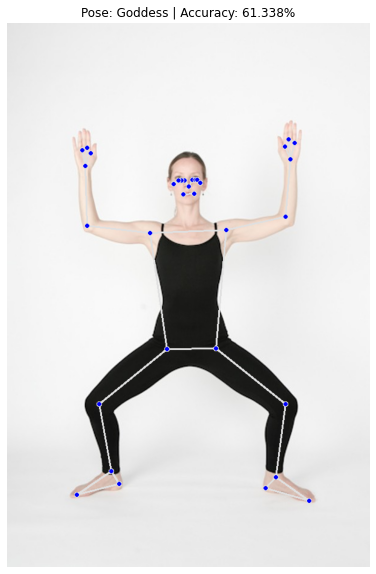

In [18]:
#MAKING PREDICTIONS
lab,acc,out=predict_with_static_image(model,path)
output(lab,acc,out)

# Machine Learning

In [19]:
import cv2 
import csv
import tqdm
import os
import sys
import pickle
import numpy as np
import mediapipe as mp 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline 
from sklearn.preprocessing import StandardScaler 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [20]:
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True,
    min_detection_confidence=0.5)

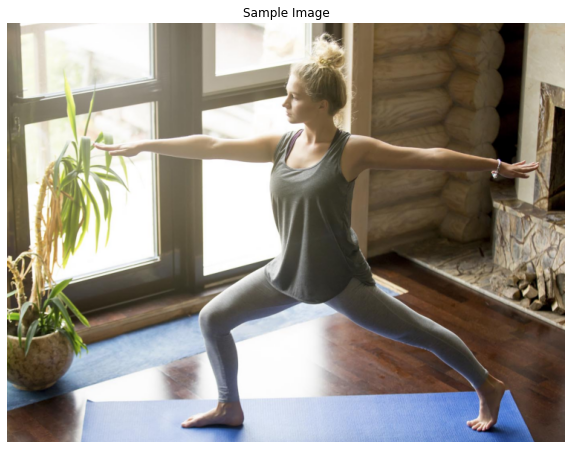

In [22]:
#PLOTTING SAMPLE IMAGE
image = cv2.imread('sample.png')
plt.figure(figsize = [10, 10])
plt.title("Sample Image")
plt.axis('off')
plt.imshow(image[:,:,::-1])
plt.show()

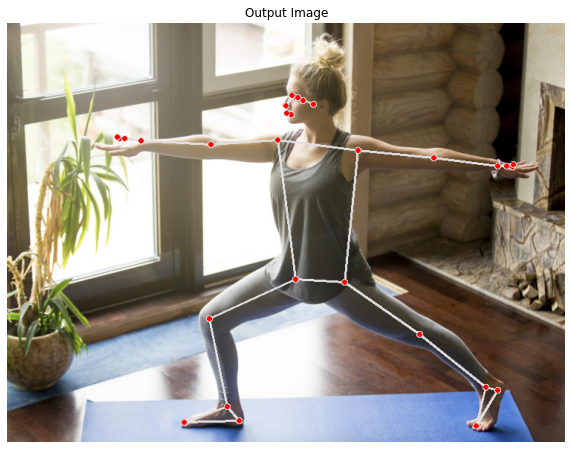

In [23]:
results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
img_copy = image.copy()
if results.pose_landmarks:
    mp_drawing.draw_landmarks(image=img_copy, landmark_list=results.pose_landmarks, connections=mp_pose.POSE_CONNECTIONS)
    plt.figure(figsize = [10, 10])
    plt.title("Output Image")
    plt.axis('off')
    plt.imshow(img_copy[:,:,::-1])
    plt.show()

In [24]:
results.pose_landmarks

landmark {
  x: 0.4996580183506012
  y: 0.19887426495552063
  z: -0.22879824042320251
  visibility: 0.9999746084213257
}
landmark {
  x: 0.5133399963378906
  y: 0.17901450395584106
  z: -0.24120354652404785
  visibility: 0.9998927116394043
}
landmark {
  x: 0.5169683694839478
  y: 0.17972642183303833
  z: -0.24115681648254395
  visibility: 0.9999110698699951
}
landmark {
  x: 0.520959734916687
  y: 0.18048220872879028
  z: -0.2412019819021225
  visibility: 0.9998927116394043
}
landmark {
  x: 0.5093477368354797
  y: 0.1768796443939209
  z: -0.20368269085884094
  visibility: 0.9998950958251953
}
landmark {
  x: 0.5098597407341003
  y: 0.17606589198112488
  z: -0.20378555357456207
  visibility: 0.9999046325683594
}
landmark {
  x: 0.5104326009750366
  y: 0.17509937286376953
  z: -0.20381668210029602
  visibility: 0.999893069267273
}
landmark {
  x: 0.5486423969268799
  y: 0.1959303617477417
  z: -0.23856855928897858
  visibility: 0.9999243021011353
}
landmark {
  x: 0.5301190614700317
  

In [25]:
num_coords=len(results.pose_landmarks.landmark)
print(num_coords)

33


In [26]:
landmarks = ['Class']
for val in range(1, num_coords+1):
    landmarks += ['X{}'.format(val), 'Y{}'.format(val), 'Z{}'.format(val)]

In [27]:
with open('coords.csv', mode='w', newline='') as f:
    csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    csv_writer.writerow(landmarks)

In [28]:
images_in_folder = 'DATASET/TRAIN'
csv_out_path = 'coords.csv'
class_names = ["Down Dog","Goddess","Plank","Tree","Warrior II"]
folder_names = ["downdog","goddess","plank","tree","warrior2"]

In [29]:
def getcoords(class_name,images_in_folder):    
    image_names = [n for n in os.listdir(images_in_folder) if not n.startswith('.')]
    print('Inserting Data in CSV of class',class_name, file=sys.stderr)
    for image_name in tqdm.tqdm(image_names, position=0):
        input_frame = cv2.imread(os.path.join(images_in_folder,image_name))
        input_frame = cv2.cvtColor(input_frame, cv2.COLOR_BGR2RGB)
        result = pose.process(image=input_frame)
        try:
            pose_landmarks = result.pose_landmarks.landmark
            row = list(np.array([[landmark.x, landmark.y, landmark.z] for landmark in pose_landmarks]).flatten())
            row.insert(0, class_name)
            with open('coords.csv', mode='a', newline='') as f:
                csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
                csv_writer.writerow(row) 
        except:
            pass

In [30]:
#INSERTING LANDMARKS IN CSV
for i in range(len(class_names)):
    getcoords(class_names[i],os.path.join(images_in_folder,folder_names[i]))

Inserting Data in CSV of class Down Dog
100%|████████████████████████████████████████████████████████████████████████████████| 223/223 [00:39<00:00,  5.63it/s]
Inserting Data in CSV of class Goddess
100%|████████████████████████████████████████████████████████████████████████████████| 180/180 [00:29<00:00,  6.15it/s]
Inserting Data in CSV of class Plank
100%|████████████████████████████████████████████████████████████████████████████████| 266/266 [00:43<00:00,  6.18it/s]
Inserting Data in CSV of class Tree
100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:31<00:00,  5.07it/s]
Inserting Data in CSV of class Warrior II
100%|████████████████████████████████████████████████████████████████████████████████| 252/252 [00:42<00:00,  5.87it/s]


In [31]:
#READING DATA FROM CSV
df = pd.read_csv('coords.csv')
df.shape

(1042, 100)

In [32]:
#STORING FEATURES AND TARGET VALUE
df_copy=df.copy(deep=True)
X = df_copy.drop('Class', axis=1)
y = df_copy['Class'] 

In [33]:
#SPLITTING DATA
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [34]:
#MAKING PIPELINES
pipelines = {
    'lr':make_pipeline(StandardScaler(), LogisticRegression(solver='lbfgs', max_iter=5000)),
    'rc':make_pipeline(StandardScaler(), RidgeClassifier()),
    'rf':make_pipeline(StandardScaler(), RandomForestClassifier()),
    'gb':make_pipeline(StandardScaler(), GradientBoostingClassifier()),
    'kn':make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=5)),
}

In [35]:
#FITTING MODEL
fit_models = {}
for algo, pipeline in pipelines.items():
    model = pipeline.fit(X_train, y_train)
    fit_models[algo] = model

In [36]:
#MODELS
fit_models

{'lr': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression', LogisticRegression(max_iter=5000))]),
 'rc': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('ridgeclassifier', RidgeClassifier())]),
 'rf': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier', RandomForestClassifier())]),
 'gb': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('gradientboostingclassifier', GradientBoostingClassifier())]),
 'kn': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('kneighborsclassifier', KNeighborsClassifier())])}

In [37]:
#EVALUATING MODELS
for algo, model in fit_models.items():
    yhat = model.predict(X_test)
    print(algo,':',accuracy_score(y_test, yhat))

lr : 0.8849840255591054
rc : 0.8849840255591054
rf : 0.9169329073482428
gb : 0.9265175718849841
kn : 0.8562300319488818


In [38]:
#STORING BEST MODEL
with open('detect_pose.pkl', 'wb') as f:
    pickle.dump(fit_models['gb'], f)

In [39]:
#LOADING MODEL
with open('detect_pose.pkl', 'rb') as f:
    model = pickle.load(f)

In [40]:
#FUNCTION TO MAKE DETECTION USING IMAGE
def make_detections(image):
    input_frame = cv2.imread(image)
    input_frame = cv2.cvtColor(input_frame, cv2.COLOR_BGR2RGB)
    result = pose.process(image=input_frame)
    output_image = input_frame.copy()
    label = "Unknown Pose"
    accuracy = 0
    mp_drawing.draw_landmarks(image=output_image, landmark_list=result.pose_landmarks, 
                                  connections=mp_pose.POSE_CONNECTIONS)
    pose_landmarks = result.pose_landmarks.landmark
    row = list(np.array([[landmark.x, landmark.y, landmark.z] for landmark in pose_landmarks]).flatten())
    X = pd.DataFrame([row])
    label = model.predict(X)[0]
    body_language_prob = model.predict_proba(X)[0]
    accuracy = str(round(body_language_prob[np.argmax(body_language_prob)]*100,3))
    if(float(accuracy)<50):
        label = "Unknown Pose"
    return label,accuracy,output_image

In [41]:
#OUTPUT
def output(lab,acc,out):
    plt.figure(figsize = [10, 10])
    if(lab=="Unknown Pose"):
        plt.title(lab)
    else:
        plt.title(f"Pose: {lab} | Accuracy: {acc}%")
    plt.axis('off')
    plt.imshow(out)
    plt.show()

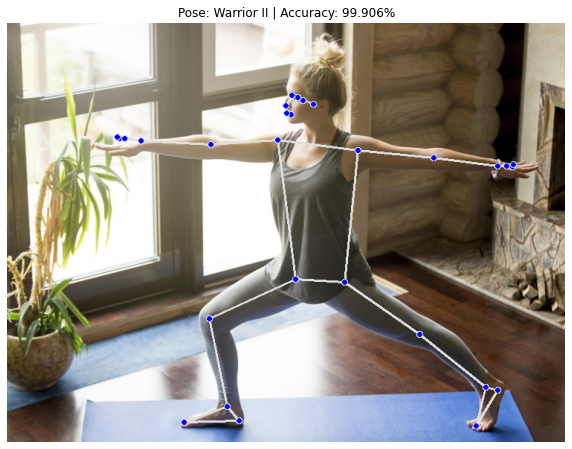

In [42]:
#PREDICTION
lab,acc,out=make_detections('sample.png')
output(lab,acc,out)